# Import Packages

In [2]:
# import the rnn and bilstm models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import  SimpleRNN, GRU
# import the scaler
from sklearn.preprocessing import MinMaxScaler
# import early stopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# import the metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import pandas
import pandas as pd
import numpy as np
# import adam optimizer
from keras.optimizers import Adam

# import matplotlib
import matplotlib.pyplot as plt
from keras import backend as K


import pickle

import datetime as dt
import os

import pandas_datareader.data as web
#import pandas.plotting
from pandas.plotting import register_matplotlib_converters
#import pandas.testing
from pandas.testing import assert_frame_equal


import matplotlib.pyplot as plt

from matplotlib import style



# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
# calculate the MAE
from sklearn.metrics import mean_absolute_error

# calculate the MAPE
from sklearn.metrics import mean_absolute_percentage_error

# calculate the MDA
from sklearn.metrics import max_error


style.use('ggplot')


In [3]:
# try the function
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2022, 1, 1)
def save_stock(stock_name, start, end):
    df = web.DataReader(stock_name, 'yahoo', start, end)
    if not os.path.exists('stock_data'):
        os.makedirs('stock_data')
    df.to_csv('stock_data/{}.csv'.format(stock_name))
    return df

In [30]:
def plot_stock(df):
    plt.figure(figsize=(16,8))
    # plot the Adj Close
    plt.plot(df['Adj Close'], label='Adj Close Price history')
    #plt.plot(df['Open'], label='Open Price history')
    #plt.plot(df['Close'], label='Close Price history')
    plt.title('Adj Close Price History')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price USD ($)')
    plt.legend()
    plt.show()

    

In [5]:
def preprocess(df,RNN_params):
    # scale the data
    
    # drop everything except the Adj Close as it is the only feature
    df = df.drop(['Open','High', 'Low', 'Close', 'Volume'], axis=1)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df)
    train = df[:RNN_params['split_date']]
    test = df[RNN_params['split_date']:]
    print('train shape: ', train.shape)
    print('test shape: ', test.shape)
    # save the size of the training set
    train_size = len(train)
    
    # split the scaled data into training and testing based on the train_size
    train = scaled_data[:train_size,:]
    test = scaled_data[train_size:,:]
    print('train shape: ', train.shape)
    print('test shape: ', test.shape)
    # plot the scaled data
    plt.figure(figsize=(16,8))
    plt.title('Scaled Data')
    plt.xlabel('Date')
    plt.ylabel('Scaled Adj Close Price USD ($)')
    plt.plot(scaled_data, label='Scaled Data')
    plt.legend()
    plt.show()
    # create the X_train and y_train
    X_train = []
    y_train = []
    for i in range(RNN_params['window'], len(train)):
        X_train.append(train[i-RNN_params['window']:i, 0])
        y_train.append(train[i, 0])
    # convert to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    # reshape the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    

    # create the X_test and y_test
    X_test = []
    y_test = []
    for i in range(RNN_params['window'], len(test)):
        X_test.append(test[i-RNN_params['window']:i, 0])
        y_test.append(test[i, 0])
    # convert to numpy arrays
    X_test, y_test = np.array(X_test), np.array(y_test)
    # reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler

    

In [6]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


def mda(y_true, y_pred, t=12):
    d = K.equal(K.sign(y_true[t: ] - y_true[:-t]),
                K.sign(y_pred[t: ] - y_pred[:-t]))
    return K.mean(K.cast(d, K.floatx()))

def build_model(RNN_params,X_train):
    # build the model
    model = Sequential()
    if RNN_params['model'] == 'LSTM':
        for i in range(RNN_params['layers']-1):
            if i == 0:
                model.add(LSTM(units=RNN_params['units'], return_sequences=True, input_shape=(X_train.shape[1], 1)))
            else:
                model.add(LSTM(units=RNN_params['units'], return_sequences=True))
            model.add(Dropout(RNN_params['dropout']))
        
        model.add(LSTM(units=RNN_params['units']))
        model.add(Dropout(RNN_params['dropout']))
        model.add(Dense(units=1))
        model.compile(optimizer=RNN_params['optimizer'], loss=RNN_params['loss'])
        
    elif RNN_params['model'] == 'LSTMsimp':
        for i in range(RNN_params['layers']-1):
            if i == 0:
                model.add(LSTM(units=RNN_params['units'], return_sequences=True, input_shape=(X_train.shape[1], 1)))
            else:
                model.add(LSTM(units=RNN_params['units'], return_sequences=True))
            model.add(Dropout(RNN_params['dropout']))
        model.add(LSTM(units=RNN_params['units']))
        model.add(Dropout(RNN_params['dropout']))
        model.add(Dense(RNN_params['FC_size'], activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=RNN_params['optimizer'], loss=RNN_params['loss'])

    elif RNN_params['model'] == 'GRU':
        for i in range(RNN_params['layers']-1):
            if i == 0:
                model.add(GRU(units=RNN_params['units'], return_sequences=True, input_shape=(X_train.shape[1], 1)))
            else:
                model.add(GRU(units=RNN_params['units'], return_sequences=True))
            model.add(Dropout(RNN_params['dropout']))
        model.add(GRU(units=RNN_params['units']))
        model.add(Dropout(RNN_params['dropout']))
        model.add(Dense(units=1))
        model.compile(optimizer=RNN_params['optimizer'], loss=RNN_params['loss'])

    elif RNN_params['model'] == 'RNN':
        for i in range(RNN_params['layers']):
            if i == 0:
                model.add(SimpleRNN(units=RNN_params['units'], return_sequences=True, input_shape=(X_train.shape[1], 1)))
            else:
                model.add(SimpleRNN(units=RNN_params['units'], return_sequences=True))
            model.add(Dropout(RNN_params['dropout']))
        model.add(SimpleRNN(units=RNN_params['units']))
        model.add(Dropout(RNN_params['dropout']))
        model.add(Dense(units=1))
        model.compile(optimizer=RNN_params['optimizer'], loss=RNN_params['loss'])
    
    else:
        print('Please choose a valid model')
    return model
    


In [7]:
# plot the training loss and validation loss, note that model has no attribute history
# so we need to use the history variable to plot the loss
def plot_loss(history):
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [8]:
# train the model
def train_model(model, X_train, y_train, RNN_params):
    # train the model and add patience with min_delta to stop training when the loss is not improving,
    # also reduce the learning rate with factor from RNN_params and patience and min delta
    # to stop reducing the learning rate when the loss is not improving, the loss is from RNN_params mean_squared_error
    # the optimizer is from RNN_params
    # the metrics is from RNN_params
    # the batch size is from RNN_params
    # the epochs is from RNN_params
    # the RNN_params in the shape "earlystop": {"patience": 20,"min_delta": 0.00001},
              #"reduce_lr": {"factor": 0.1,
                          #  "patience": 10,
                           # "min_delta": 0.0001}
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=RNN_params["reduce_lr"]["factor"], patience=RNN_params["reduce_lr"]["patience"], min_delta=RNN_params["reduce_lr"]["min_delta"], mode='min')
    earlystop = EarlyStopping(monitor='loss', min_delta=RNN_params["earlystop"]["min_delta"], patience=RNN_params["earlystop"]["patience"], mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=RNN_params['epochs'], batch_size=RNN_params['batch_size'], callbacks=[reduce_lr, earlystop])
    return history, model

# test the model
def test_model(model, X_train,y_train,X_test, y_test, scaler):
    # predict the test set
    y_pred_train = model.predict(X_train)
    # get the data of the scaler
    #print(scaler.data_max_)
    # inverse the scaling
    y_pred_train = scaler.inverse_transform(y_pred_train)
    # inverse the y_test but reshape it to the input shape of the scaler
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))


    # predict the test set
    y_pred_test = model.predict(X_test)
    # get the data of the scaler
    #print(scaler.data_max_)
    # inverse the scaling
    y_pred_test = scaler.inverse_transform(y_pred_test)
    # inverse the y_test but reshape it to the input shape of the scaler
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    
    return y_pred_train, y_train, y_pred_test, y_test



In [9]:

# plot the predictions
def plot_predictions(real_stock_price, predicted_stock_price):
    # plot the predictions
    plt.figure(figsize=(16,8))
    plt.plot(real_stock_price, color='red', label='Real Stock Price')
    plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()



In [10]:
# get the last window and predict the next range of days
def predict_next_days(df,model,RNN_params,scaler,y_pred_train,y_pred_test,X_test,y_test):
    days = RNN_params['days']

    last_window = X_test[-1]
    #print(last_window.shape)
    last_window = np.reshape(last_window, (1, last_window.shape[0], 1))
    #print(last_window.shape)
    #print(last_window[0])

    predictions = []
    for i in range(days):
        pred = model.predict(last_window)
        predictions.append(pred[0][0])
        last_window = np.append(last_window[0][1:], pred)
        last_window = np.reshape(last_window, (1, last_window.shape[0], 1))
    #print(predictions)
    #print(predictions.shape)

    # inverse the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    #print(predictions)

    # plot the predictions
    plt.figure(figsize=(16,8))
    plt.plot(predictions, color='blue', label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()



    # copy the dataframe to a new dataframe called future
    future = df.copy()
    #print(future.tail(10))
    #print(future.shape)
    # add 30 rows to the dataframe
    # calculate how many rows to add with the given days taking into account the holidays saterday and sunday
    rows = days + (days//5)*2
    #print(rows)
    for i in range(rows):
        future.loc[future.index.max() + pd.DateOffset(days=1)] = [np.nan] * len(future.columns)

    #print(future.tail(10))
    # reset the index
    future.reset_index(inplace=True)
    #print(future.tail(10))
    # get the name of the day of the date column 
    future['day'] = future['Date'].dt.day_name()
    #print(future.tail(10))
    # drop the row that has satensday and sunday
    future = future[future['day'] != 'Saturday']
    future = future[future['day'] != 'Sunday']
    # drop the day column
    future.drop('day', axis=1, inplace=True)

    # set the date column as the index
    future.set_index('Date', inplace=True)
    #print(future.tail(31))
    # strip the predictions list 
    predictions = predictions.flatten()
    #print(predictions)
    # add the predictions to the last 'days' rows of the dataframe
    future['Adj Close'].iloc[-days:] = predictions


    #print(future.tail(31))
    # add the X_train_pred and y_train_pred to the dataframe under one column called train_test_pred
    future['train_test_pred'] = np.nan

    # train_test_pred = the RNN['window'] of future['Adj Close'] 
    train_test_pred = future['Adj Close'].iloc[:RNN_params['window']]


    # print the values of train_test_pred
    #print(train_test_pred.values)
    # convert the train_test_pred values to a numpy array
    train_test_pred = np.array(train_test_pred)
    # concatenate the train_test_pred and y_pred_train
    train_test_pred = np.concatenate((train_test_pred, y_pred_train))

    # get another RNN['window'] of future['Adj Close'] after the y_pred_train
    to_be_added = future['Adj Close'].iloc[RNN_params['window']+len(y_pred_train):RNN_params['window']+len(y_pred_train)+RNN_params['window']]
    # convert the to_be_added values to a numpy array
    to_be_added = np.array(to_be_added)
    # concatenate the train_test_pred and to_be_added
    train_test_pred = np.concatenate((train_test_pred, to_be_added))

    # concatenate the train_test_pred and y_pred_test
    train_test_pred = np.concatenate((train_test_pred, y_pred_test))
    # add the train_test_pred to the future dataframe - days
    future['train_test_pred'].iloc[:-days] = train_test_pred



    # # copy the RNN_params['window'] rows from the future['Adj Close'] to the future['train_test_pred']
    # future['train_test_pred'].iloc[:RNN_params['window']] = future['Adj Close'].iloc[:RNN_params['window']]
    # # copy the y_pred_train after the RNN_params['window'] to the future['train_test_pred']
    # future['train_test_pred'].iloc[RNN_params['window']:RNN_params['window']+len(y_pred_train)] = y_pred_train
    # # copy the y_pred_test after the RNN_params['window']+len(y_pred_train) to the future['train_test_pred']
    # slicer = 2*(RNN_params['window'])+len(y_pred_train)
    # future['train_test_pred'].iloc[RNN_params['window']+len(y_pred_train):slicer] = future['Adj Close'].iloc[RNN_params['window']+len(y_pred_train):slicer]
    # # copy the y_pred_test after the 2*RNN_params['window']+len(y_pred_train) to the future['train_test_pred']
    # future['train_test_pred'].iloc[slicer:] = y_pred_test





    #print(y_pred_train.shape)
    #print(y_pred_train[0])

    # plot the Adj Close price in blue without the last 'days' rows and in red with the last 'days' rows
    plt.figure(figsize=(16,8))
    plt.plot(future['Adj Close'][:-days], color='blue', label='Real Stock Price')
    plt.plot(future['Adj Close'][-days:], color='red', label='forecast Stock Price')
    plt.plot(future['train_test_pred'], color='green', label='Train Test Predictions')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()



In [11]:
def evaluation(real_stock_price, predicted_stock_price):
    rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    print('Test RMSE: %.3f' % rmse)



    mae = mean_absolute_error(real_stock_price, predicted_stock_price)
    print('Test MAE: %.3f' % mae)


    mape = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
    print('Test MAPE: %.3f' % mape)


    mda = max_error(real_stock_price, predicted_stock_price)
    print('Test MDA: %.3f' % mda)
# save the model
def save_model(model, scaler, RNN_params):
    # save the model with the name of the company from the RNN_params dictionary and name of the model, save in a folder called models and inside this folder create a folder with the name of the company
    if not os.path.exists('models'):
        os.makedirs('models')
    if not os.path.exists('models/'+RNN_params['company']):
        os.makedirs('models/'+RNN_params['company'])
    model.save('models/'+RNN_params['company']+'/'+RNN_params['model']+'.h5')
    # save the scaler with the name of the company from the RNN_params dictionary and name of the model
    pickle.dump(scaler, open('models/'+RNN_params['company']+'/'+RNN_params['model']+'_scaler.pkl', 'wb'))





In [35]:
# use the save_stock function to save the stock data
start_date = '2010-01-01'
end_date = '2022-03-12'
df = save_stock('AMZN', start_date, end_date)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3069 entries, 2010-01-04 to 2022-03-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3069 non-null   float64
 1   Low        3069 non-null   float64
 2   Open       3069 non-null   float64
 3   Close      3069 non-null   float64
 4   Volume     3069 non-null   int64  
 5   Adj Close  3069 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 167.8 KB
None


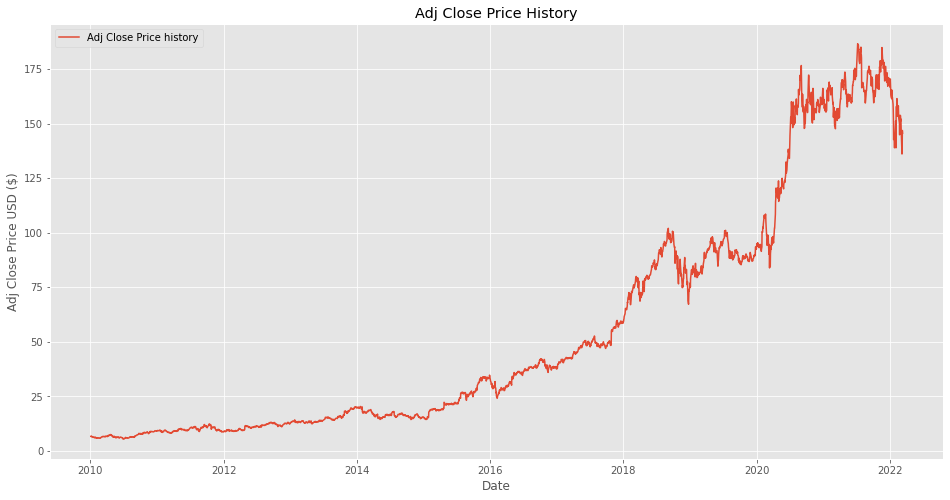

In [36]:
plot_stock(df)

train shape:  (2647, 1)
test shape:  (252, 1)
train shape:  (2647, 1)
test shape:  (252, 1)


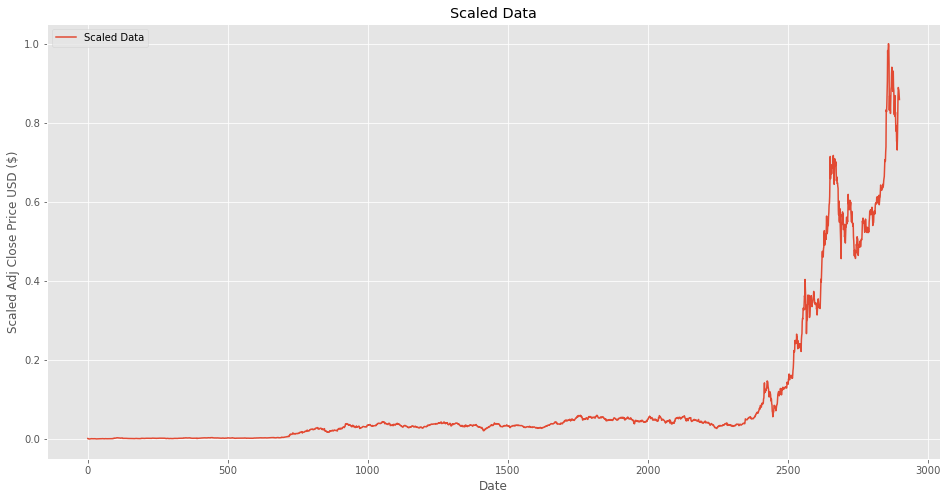

(2587, 60, 1)
(2587,)
(192, 60, 1)
(192,)


In [14]:
# use the preprocess function to preprocess the data
RNN_params = {"window": 60,
                "model": 'LSTM',
                "units": 128,
                "layers": 4,
                "dropout": 0.5,
                "loss": 'mean_squared_error',
                "optim": Adam,
                'optimizer':'adam',
                "lr": 0.0001,
                "epochs": 2,
                'FC_size': 32,
                "batch_size": 32,
                "earlystop": {"patience": 20,"min_delta": 0.00001},
                "reduce_lr": {"factor": 0.1,
                                "patience": 10,
                                "min_delta": 0.0001},
                'split_date': '2021-01-01',
                'days': 30
                }


X_train, y_train, X_test, y_test, scaler = preprocess(df, RNN_params)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



In [15]:
# use the build_model function to build the model
model = build_model(RNN_params,X_train)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)              

In [151]:
# use the train_model function to train the model
history,model = train_model(model, X_train, y_train, RNN_params)


Epoch 1/2
81/81 [==============================] - 8s 34ms/step - loss: 9.6392e-04 - lr: 0.0010
Epoch 2/2
81/81 [==============================] - 3s 32ms/step - loss: 5.6073e-04 - lr: 0.0010


In [152]:
print(X_test.shape)
print(y_test.shape)
#print(X_test[0])
#print(y_test[0])
#print(X_train[-2])
#print(X_train.shape)

(192, 60, 1)
(192,)


In [153]:
# test the model
y_pred_train, y_train, y_pred_test, y_test = test_model(model, X_train,y_train,X_test, y_test, scaler)

6/6 [==============================] - 0s 17ms/step


In [154]:
# get the shape of the real_stock_price and predicted_stock_price
print(y_train.shape)
print(y_pred_train.shape)
print(y_test.shape)
print(y_pred_test.shape)


(2587, 1)
(2587, 1)
(192, 1)
(192, 1)


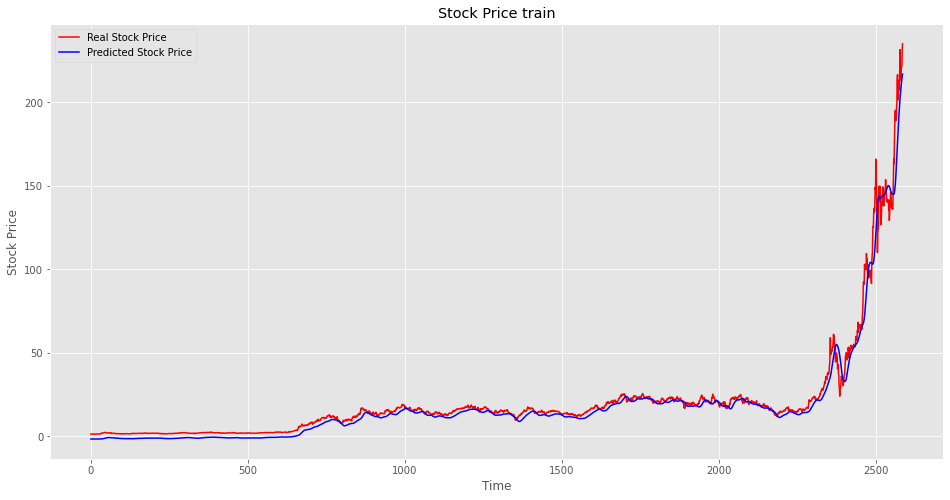

In [155]:
# plot the predictions
plt.figure(figsize=(16,8))
plt.plot(y_train, color='red', label='Real Stock Price')
plt.plot(y_pred_train, color='blue', label='Predicted Stock Price')
plt.title('Stock Price train')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()


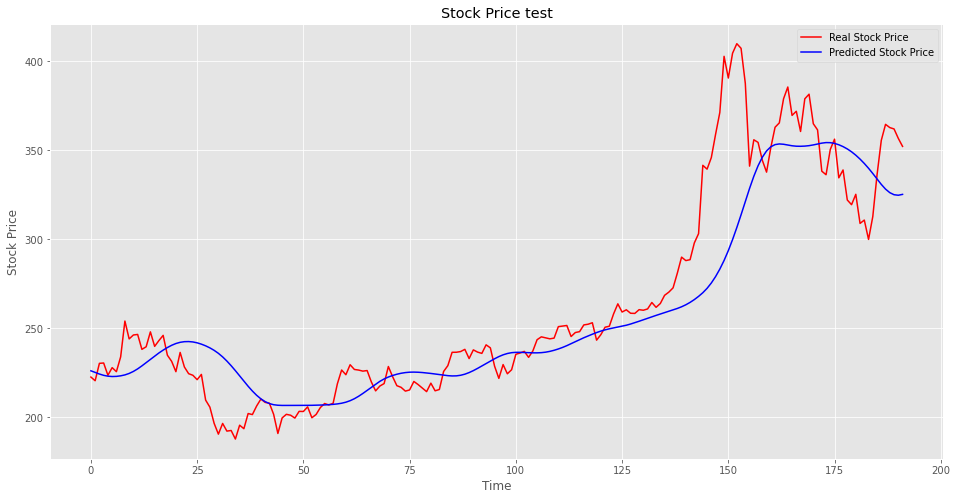

In [156]:
# plot the predictions
plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', label='Real Stock Price')
plt.plot(y_pred_test, color='blue', label='Predicted Stock Price')
plt.title('Stock Price test')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()


In [157]:
evaluation(y_test, y_pred_test)

Test RMSE: 26.565
Test MAE: 16.955
Test MAPE: 0.060
Test MDA: 114.712


In [158]:
# flatten the y_train_pred and y_test_pred
y_pred_train = y_pred_train.flatten()
y_pred_test = y_pred_test.flatten()



1/1 [==============================] - 0s 27ms/step


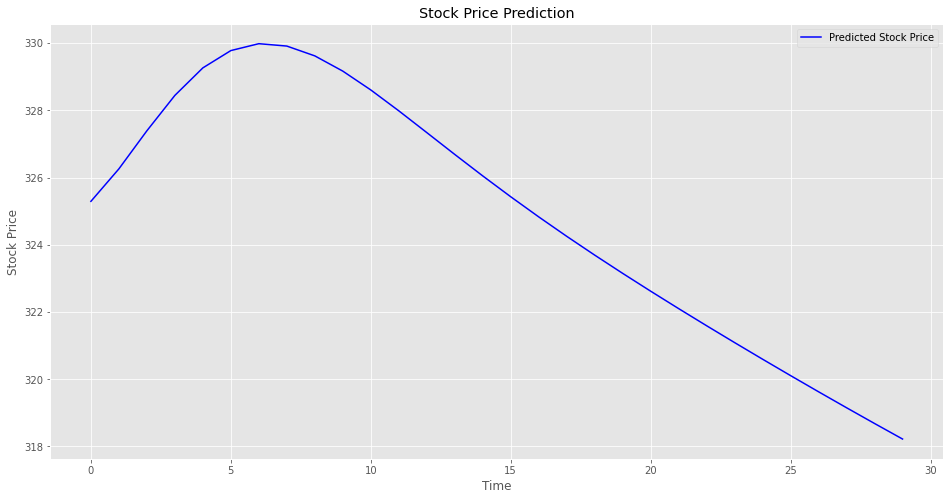

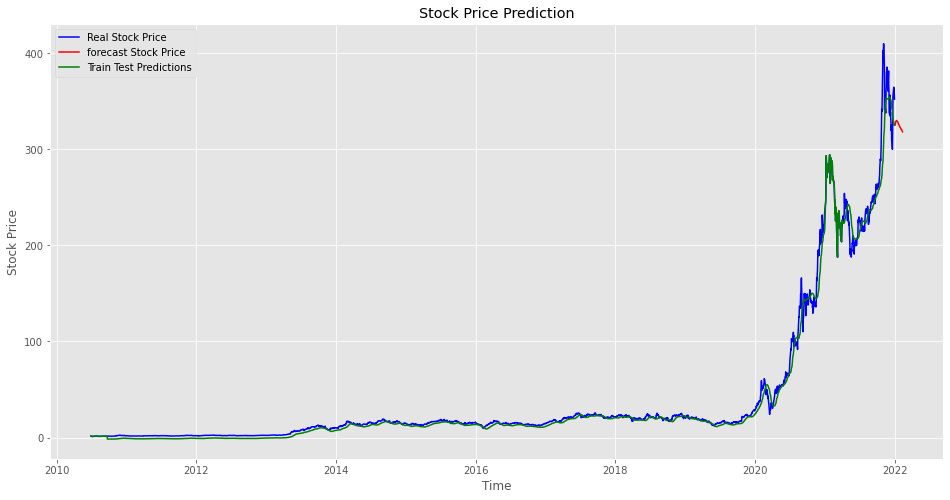

In [159]:
predict_next_days(df,model,RNN_params,scaler,y_pred_train,y_pred_test,X_test,y_test)

the data has been scarped and saved
train shape:  (2769, 1)
test shape:  (252, 1)
train shape:  (2769, 1)
test shape:  (252, 1)


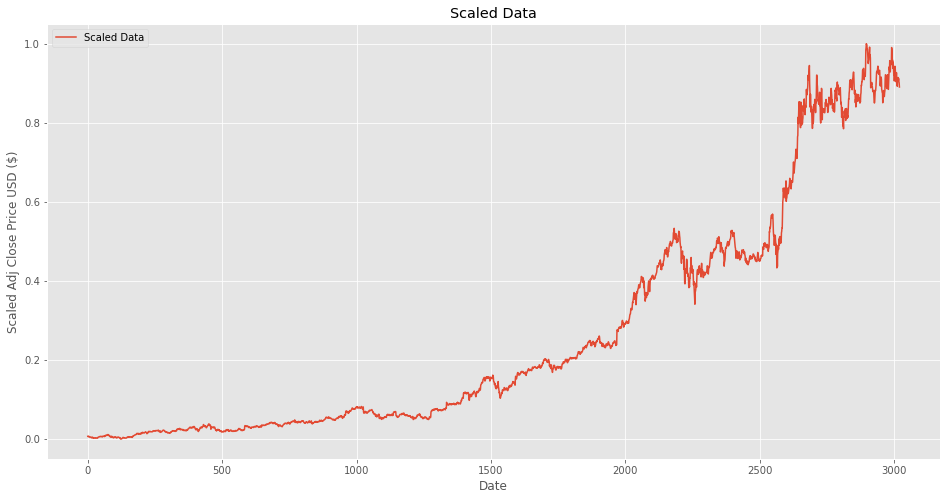

the data has been preprocessed
the model has been built
Epoch 1/120
83/83 [==============================] - 10s 57ms/step - loss: 0.0080 - lr: 0.0010
Epoch 2/120
83/83 [==============================] - 5s 54ms/step - loss: 0.0021 - lr: 0.0010
Epoch 3/120
83/83 [==============================] - 5s 55ms/step - loss: 0.0027 - lr: 0.0010
Epoch 4/120
83/83 [==============================] - 5s 55ms/step - loss: 0.0020 - lr: 0.0010
Epoch 5/120
83/83 [==============================] - 4s 54ms/step - loss: 0.0019 - lr: 0.0010
Epoch 6/120
83/83 [==============================] - 6s 70ms/step - loss: 0.0019 - lr: 0.0010
Epoch 7/120
83/83 [==============================] - 5s 60ms/step - loss: 0.0020 - lr: 0.0010
Epoch 8/120
83/83 [==============================] - 6s 78ms/step - loss: 0.0020 - lr: 0.0010
Epoch 9/120
83/83 [==============================] - 6s 68ms/step - loss: 0.0015 - lr: 0.0010
Epoch 10/120
83/83 [==============================] - 5s 63ms/step - loss: 0.0016 - lr: 0.0010
Ep

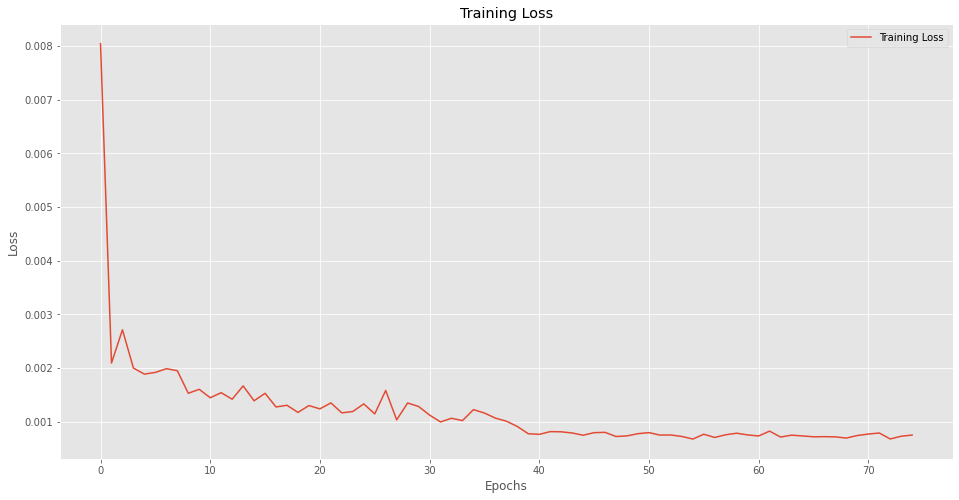

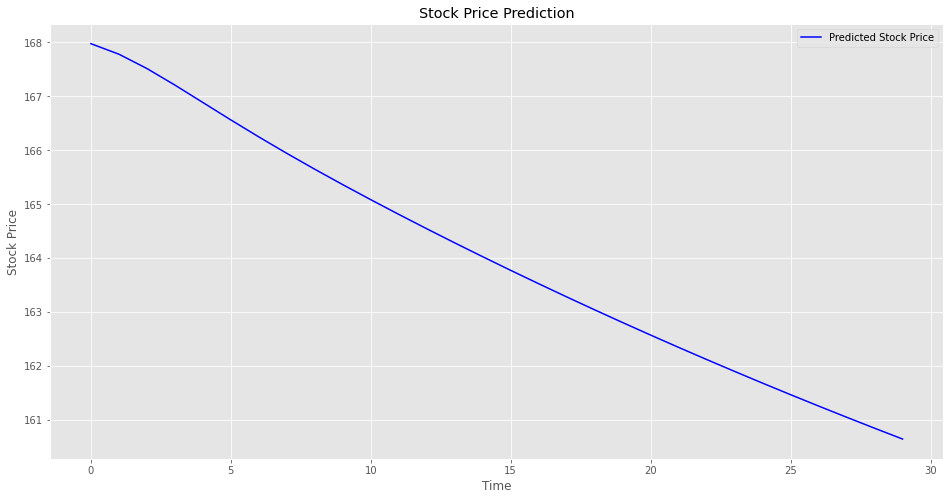

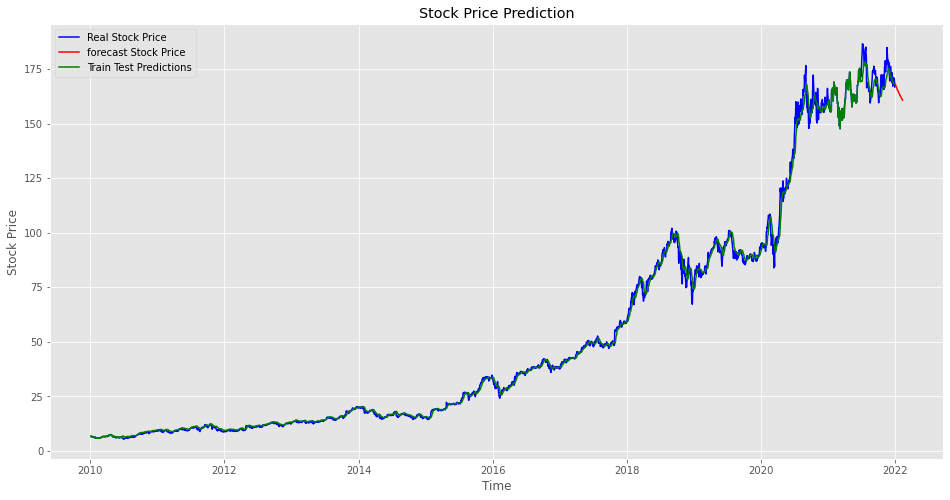

In [34]:
# main function
def main():
    RNN_params = {"company": 'AMZN',
                "window": 120,
                "model": 'LSTM',
                "units": 128,
                "layers": 4,
                "dropout": 0.5,
                "loss": 'mean_squared_error',
                "optim": Adam,
                'optimizer':'adam',
                "lr": 0.0001,
                "epochs": 120,
                'FC_size': 32,
                "batch_size": 32,
                "earlystop": {"patience": 20,"min_delta": 0.00001},
                "reduce_lr": {"factor": 0.1,
                                "patience": 10,
                                "min_delta": 0.0001},
                'split_date': '2021-01-01',
                'start_date': '2010-01-01',
                'end_date': '2022-1-01',
                'days': 30
                }


    # get the data
    df = save_stock(RNN_params['company'],RNN_params['start_date'],RNN_params['end_date'])
    print('the data has been scarped and saved')
    # preprocess the data
    X_train, y_train, X_test, y_test, scaler = preprocess(df, RNN_params)
    print('the data has been preprocessed')
    model = build_model(RNN_params,X_train)
    print('the model has been built')
    # use the train_model function to train the model
    history,model = train_model(model, X_train, y_train, RNN_params)
    print('the model has been trained')
    plot_loss(history)

    # test the model
    y_pred_train, y_train, y_pred_test, y_test = test_model(model, X_train,y_train,X_test, y_test, scaler)
    print('the model has been tested')
    

    # evaluate the model
    evaluation(y_test, y_pred_test)

    # flatten the y_train_pred and y_test_pred
    y_pred_train = y_pred_train.flatten()
    y_pred_test = y_pred_test.flatten()

    # plot the predictions
    predict_next_days(df,model,RNN_params,scaler,y_pred_train,y_pred_test,X_test,y_test)

    # save the model
    save_model(model,scaler,RNN_params)

    
if __name__ == '__main__':
    main()
    

In [37]:
from oop_final import StockBot


train shape:  (2769, 1)
test shape:  (252, 1)
train shape:  (2769, 1)
test shape:  (252, 1)


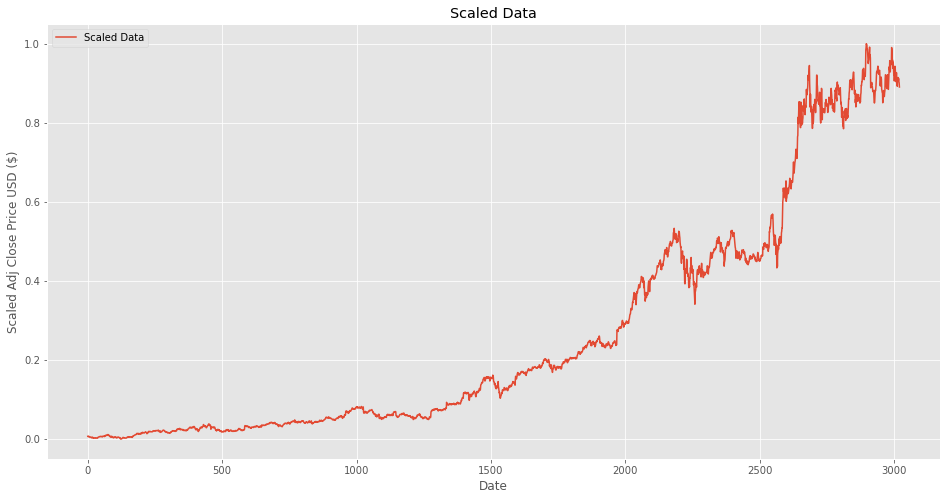

5/5 [==============================] - 0s 21ms/step
Test RMSE: 17.103
Test MAE: 15.512
Test MAPE: 0.089
Test MDA: 31.562
1/1 [==============================] - 0s 41ms/step


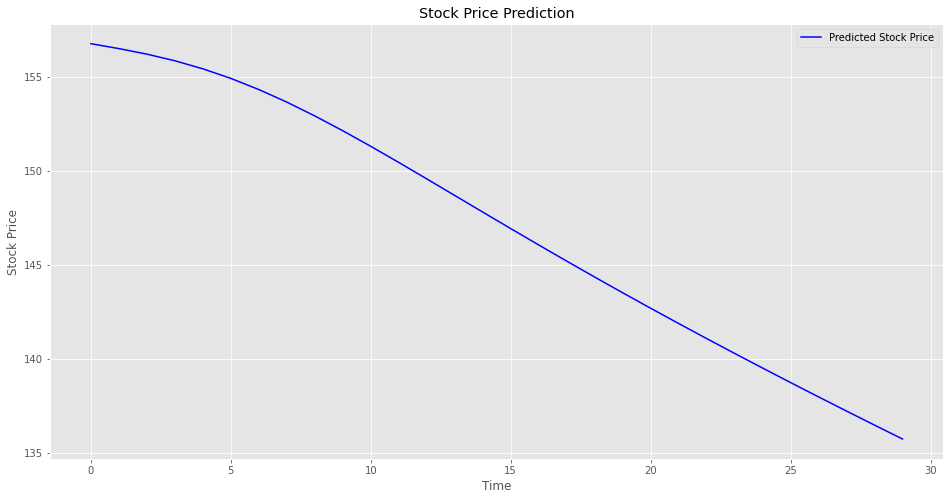

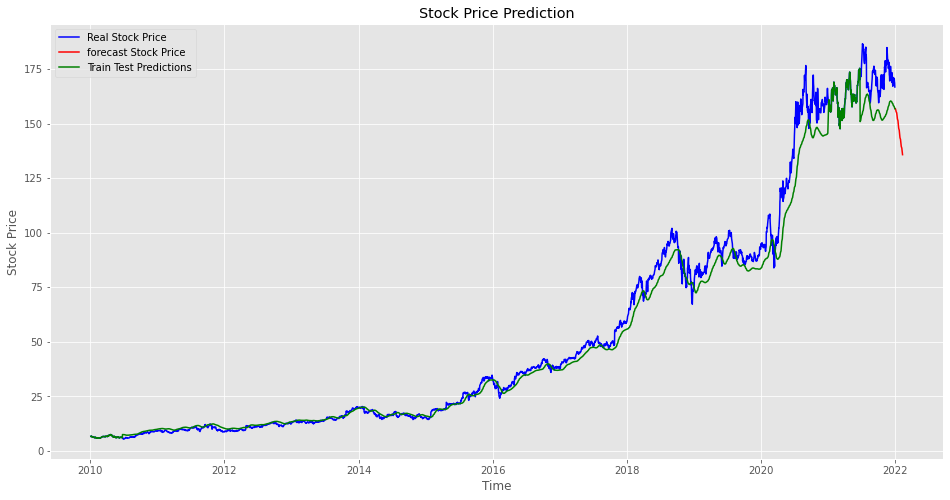

In [38]:
def main():
    RNN_params = {"company": 'AMZN',
                "window": 120,
                "model_name": 'LSTM',
                "units": 128,
                "layers": 4,
                "dropout": 0.5,
                "loss": 'mean_squared_error',
                "optim": Adam,
                'optimizer':'adam',
                "lr": 0.0001,
                "epochs": 1,
                'FC_size': 32,
                "batch_size": 32,
                "earlystop": {"patience": 20,"min_delta": 0.00001},
                "reduce_lr": {"factor": 0.1,
                                "patience": 10,
                                "min_delta": 0.0001},
                'split_date': '2021-01-01',
                'start_date': '2010-01-01',
                'end_date': '2022-1-01',
                'days': 30
                }
    x = StockBot(**RNN_params)
    #print(x.company)
    #print(x.start_date)
    #print(x.end_date)
    # save the stock data
    df = x.save_stock(RNN_params)
    X_train, y_train, X_test, y_test, scaler = x.preprocess(df, RNN_params)
    # build the model
    model = x.build_model(RNN_params,X_train)
    #model.summary()
    history, model = x.train_model(model, X_train, y_train, RNN_params)
    y_pred_train, y_train, y_pred_test, y_test = x.test_model(model, X_train,y_train,X_test, y_test, scaler)
    x.evaluation(y_test, y_pred_test)
    # flatten the y_train_pred and y_test_pred
    y_pred_train = y_pred_train.flatten()
    y_pred_test = y_pred_test.flatten()

    # plot the predictions
    x.predict_next_days(df,model,RNN_params,scaler,y_pred_train,y_pred_test,X_test,y_test)

    # save the model
    x.save_model(model,scaler,RNN_params)

if __name__ == '__main__':
    main()